In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [1]:
!nvidia-smi

Sun Sep 18 10:52:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   27C    P8     9W / 250W |    103MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P6000        Off  | 00000000:81:00.0 Off |                  Off |
| 26%   

In [8]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [68]:
df1 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/Tweets_Spring_Summer_2021_coded.csv',
                lineterminator='\n',
                skipinitialspace=True,
                )
df1['label']= 1
df1.drop(df1.columns[[0, 2,3,4]], axis=1, inplace=True)
df1

,Tweet,label
0,@aaronaxline @friskycarolina was livid to watc...,1
1,anyways. im starting my diet on Sunday. i was ...,1
2,Alcohol and drugs is good for the mind but not...,1
3,"Now that's jus sad 😂 #BuckeyeNation""62% of Ohi...",1
4,Bro do you ever get in those moods where you j...,1
...,...,...
4462,How much coke she did no wonder age OD'd. Damn.,1
4463,Ain't no salary cap in the dope game ain't no ...,1
4464,Aw man they busting out the nose candy &amp; f...,1
4465,They say crack kill nigga my crack sell #21Savage,1


In [53]:
df2 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_31_CleanedTweets.csv',
                lineterminator='\n',
                skipinitialspace=True
                )
df2.drop(df2.columns[[0, 1]], axis=1, inplace=True)
df2.rename({'text': 'Tweet'}, axis=1, inplace=True)

df2['label']= 0
df2= df2[:5000]


In [54]:
df2 = df2[:5000]
df = pd.concat([df1,df2])
df

,Tweet,label
0,@aaronaxline @friskycarolina was livid to watc...,1
1,anyways. im starting my diet on Sunday. i was ...,1
2,Alcohol and drugs is good for the mind but not...,1
3,"Now that's jus sad 😂 #BuckeyeNation""62% of Ohi...",1
4,Bro do you ever get in those moods where you j...,1
...,...,...
4995,USER one tiny slice institutional racism fashi...,0
4996,USER least one arrest far grand central manhat...,0
4997,USER make nice cup tea brew liberal tear delic...,0
4998,rick santorum waste time call witness get trut...,0


# DATA PREPROCESSING

In [ ]:
#choosing sequence length
token_lens = []
for txt in df.Tweet:
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')

# MAX_LEN = 80

In [55]:
MAX_LEN = 128
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/users/kent/jmaharja/drugAbuse/output/sept2022/TokRoBERTa'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

In [56]:
from torch.utils.data import Dataset
class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.tokenizer = tokenizer
    self.max_len = max_len
  
   def __len__(self):
    return len(self.data)
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row['label']
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding=MAX_LEN,
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [57]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((8520, 2), (473, 2), (474, 2))

In [58]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df,tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size,num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [59]:
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
# from transformers import RobertaModel, RobertaConfig, logging

class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [60]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    hidden_size=768,
    pad_token_id=1
)

model = TweetModel(config, 2)
model = model.to(device)

Some weights of the model checkpoint at /users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stre

In [61]:
#training
EPOCHS = 16

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [62]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [63]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [64]:
from os.path import exists
# %%time

# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):


#   modelPath = "/content/best_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training
  

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 0.03715697081572718 accuracy 0.9893192488262911


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 6.084695044895246e-05 accuracy 1.0

Epoch 2/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 0.0035927296548168937 accuracy 0.9985915492957746


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 5.1419122792140114e-05 accuracy 1.0

Epoch 3/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 0.0006902068962969848 accuracy 0.9998826291079812


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 0.00024271800290686467 accuracy 1.0

Epoch 4/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 5.3993941153793255e-05 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 2.9053898060737993e-06 accuracy 1.0

Epoch 5/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 0.0010031101722205716 accuracy 0.9998826291079812


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 2.5030198078942097e-06 accuracy 1.0

Epoch 6/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 3.9275159117342055e-06 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 1.8065097719954792e-06 accuracy 1.0

Epoch 7/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 2.9481553889386467e-06 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 1.3973653191593864e-06 accuracy 1.0

Epoch 8/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 2.4279333830811328e-06 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 1.1152929156802807e-06 accuracy 1.0

Epoch 9/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 1.8941573581316237e-06 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 9.295811423726264e-07 accuracy 1.0

Epoch 10/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 1.5539673191677303e-06 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 7.6522770958339e-07 accuracy 1.0

Epoch 11/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 1.4632231653930494e-06 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 5.802063971790024e-07 accuracy 1.0

Epoch 12/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 1.1124835271012086e-06 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 5.21567736200268e-07 accuracy 1.0

Epoch 13/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 9.879203406957012e-07 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 4.6996565477760063e-07 accuracy 1.0

Epoch 14/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 1.1499067541330433e-05 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 6.657361609541113e-07 accuracy 1.0

Epoch 15/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 8.107981610050129e-07 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 6.341969329544857e-07 accuracy 1.0

Epoch 16/16
----------


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Train loss 8.229102341572466e-07 accuracy 1.0


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

Val   loss 6.025195555518319e-07 accuracy 1.0



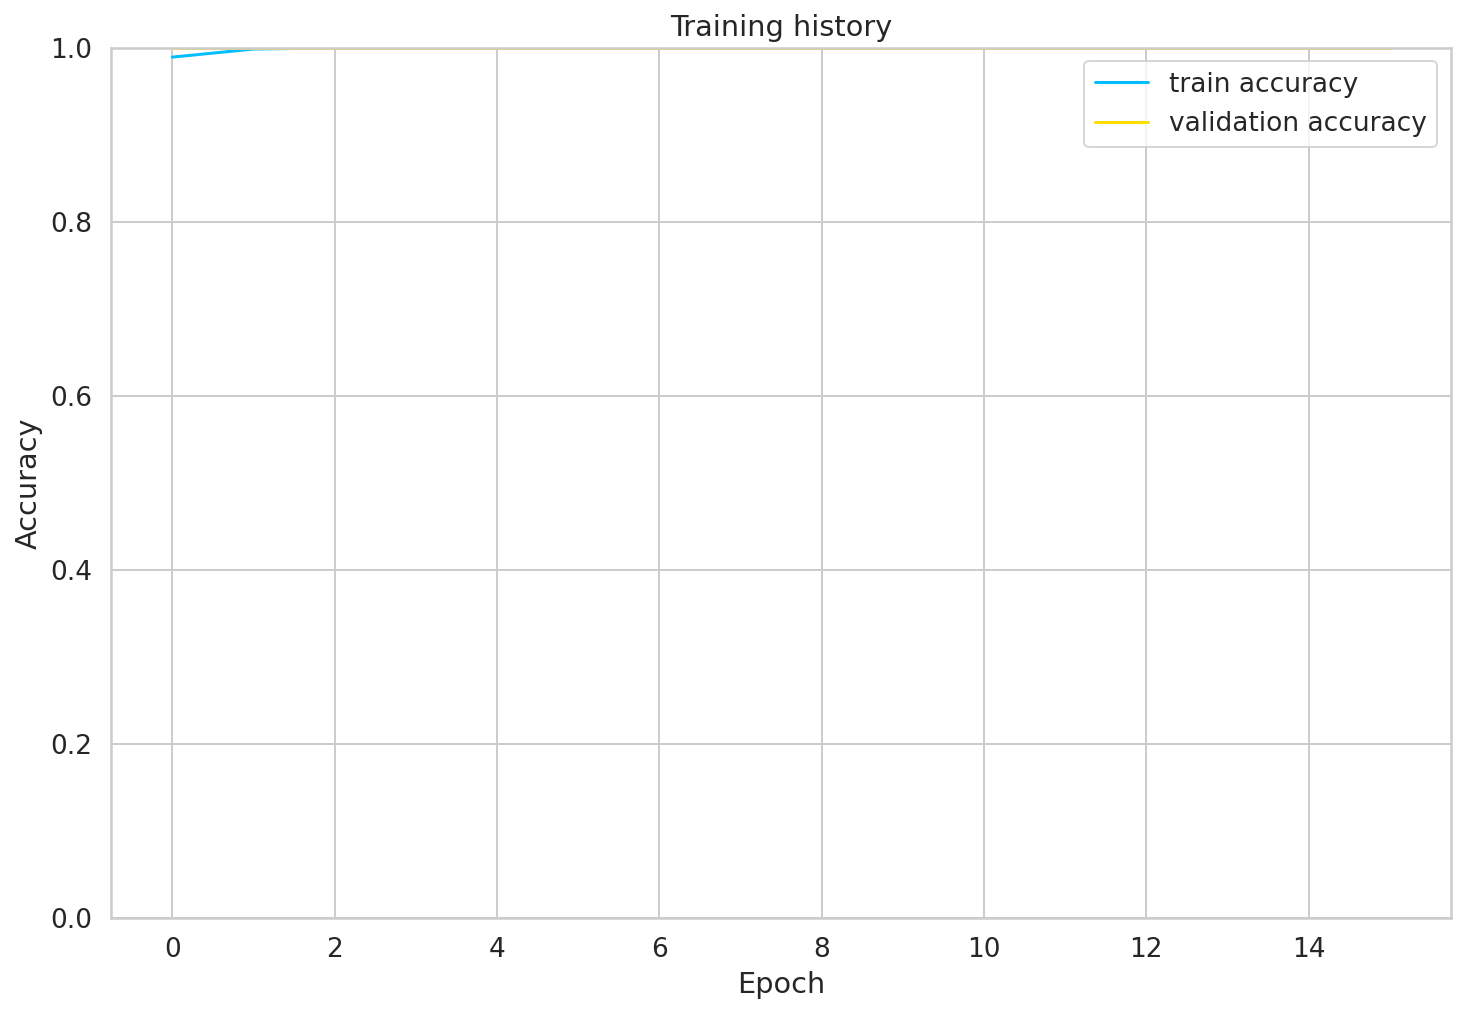

In [65]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [66]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

0.9957805907172995

In [67]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [68]:
import torch.nn.functional as F
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

In [69]:
# y_review_texts,y_pred_probs, y_pred, y_test

In [70]:
a = y_test.numpy
a

<function Tensor.numpy>

In [71]:

y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

/users/kent/jmaharja/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,readme,Real,Predicted,Pred-prob,All Pred-probs
0,USER day go think video HTTPURL,0,0,2.501921e-07,"[0.99999976, 2.5019213e-07]"
1,get joshua quiz seventeen member attract you H...,0,0,3.726962e-07,"[0.99999964, 3.7269623e-07]"
2,play tradjik lawless algeric break app google ...,0,0,4.090407e-07,"[0.99999964, 4.0904072e-07]"
3,Shiiiiit this @vincestaples song is so dope. N...,1,1,9.999998e-01,"[2.9127887e-07, 0.99999976]"
4,USER USER USER USER get it remember “ black ha...,0,0,2.664348e-07,"[0.99999976, 2.6643482e-07]"
...,...,...,...,...,...
469,USER know measles reset immune system even per...,0,0,2.572248e-07,"[0.99999976, 2.5722483e-07]"
470,Good luck to the freshman and JV teams as they...,1,1,9.999998e-01,"[2.9732195e-07, 0.99999976]"
471,But you guys were drunk https://t.co/d8hdjxHqPu,1,1,9.999996e-01,"[3.042073e-07, 0.99999964]"
472,Basketball https://t.co/InJA5FHuOj,1,1,9.999996e-01,"[3.0058405e-07, 0.99999964]"


In [72]:
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

              precision    recall  f1-score   support

           Y       1.00      1.00      1.00       262
           N       1.00      1.00      1.00       212

    accuracy                           1.00       474
   macro avg       1.00      1.00      1.00       474
weighted avg       1.00      1.00      1.00       474



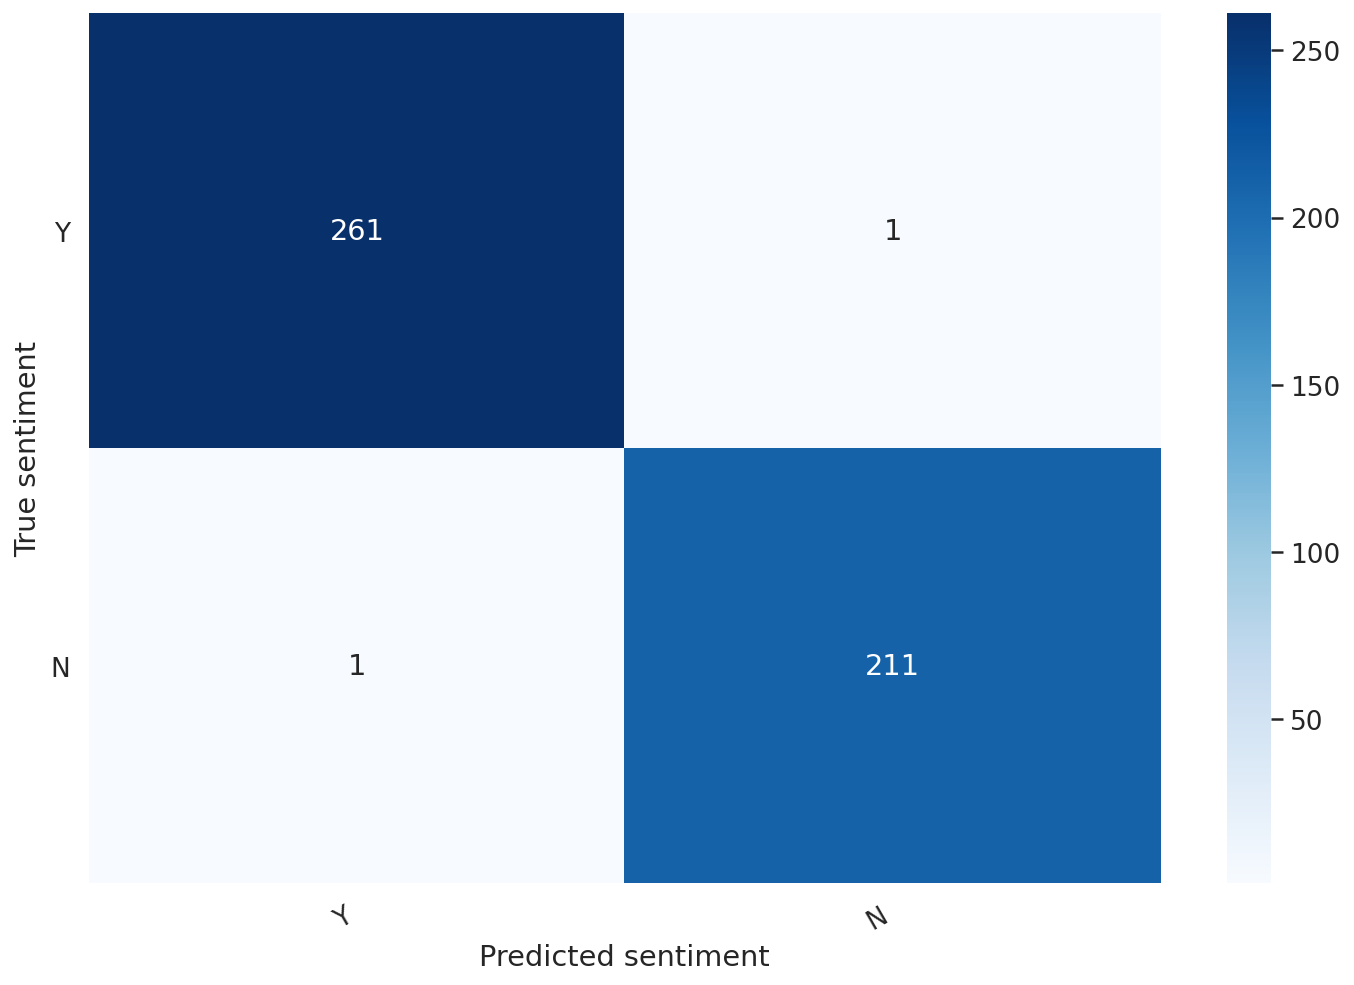

In [73]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)